# Self-Supervised Moncular Depth Estimation using Neural Networks
## CS 484 Fall 2023 Final Project
### By: Nimun Bajwa
### Email: n2bajwa@uwaterloo.ca


## Introduction


Monocular depth estimation is a computer vision task that involves estimating the depth of each pixel given a single 2D (monocular) image. The goal is to derive 3D information from a 2D image.

While many depth-estimation techniques exist like multi-view geometry and stereo reconstruction, machine learning can do better. Learning techniques had been shown to be promising, but most of them utilized fully supervised learning, which relied on having a considerable amount of ground truth depth data at hand.

In 2017, Clément Godard, Oisin Mac Aodha, and Gabriel J. Brostow published a paper titled "Unsupervised Monocular Depth Estimation with Left-Right Consistency" (https://arxiv.org/abs/1609.03677) This paper proposed a new technique for depth estimation which utilized unsupervised or self-supervised learning. It suggests a novel training method (a unique loss function) which allows the CNN to perform depth estimation on a single image, without ground truth data. 

This method uses left-right image pairs taken by parallel cameras at a given base-length. It uses the left image to estimate both the left-to-right and right-to-left disparity maps. The left-to-right disparity map is used to reconstruct the right image, and the right-to-left disparity map is used to reconstruct the left image. The reconstructed images are then compared with the original images, and used to drive the loss function. 

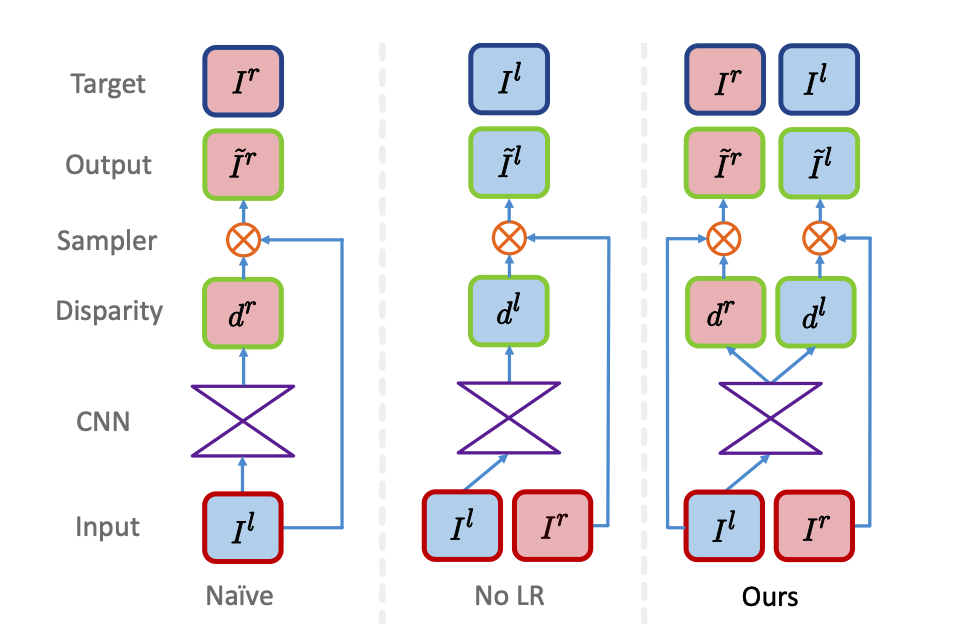

## Imports

In [1]:
%matplotlib inline
USE_GPU = False

In [2]:
# Python Libraries
import random
import math
import numbers
import platform
import copy

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# We import some of the main PyTorch and TorchVision libraries.
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset
We will be using the KITTI dataset for training our model. Specifically, we will be using left-right image pairs.

The training set consists of:
- 2011_09_29_drive_0071 (1059 image pairs)

The validation set consists of:
- 2011_09_28_drive_0001 (106 image pairs)

The sanity set consists of
- 1 left/right image pair (just to test if things seem to be working)

We will only be using colored images. I have 3 folders in my data folder: train, validate, and sanity. Each folder contains a data folder with two sub-folders called left and right, which contain the image pairs of the same name. 

Folder setup:
```
data
│
├── train
│   ├── left
│   │   ├── 0000000000.png
│   │   ├── ...
│   │   └── 0000001059.png
│   └── right
│       ├── 0000000000.png
│       ├── ...
│       └── 0000001059.png
│
├── validate
│   ├── left
│   │   ├── 0000000000.png
│   │   ├── ...
│   │   └── 0000000105.png
│   └── right
│       ├── 0000000000.png
│       ├── ...
│       └── 0000000105.png
│
└── sanity
    ├── left
    │   └── 0000000000.png
    └── right
        └── 0000000000.png
```

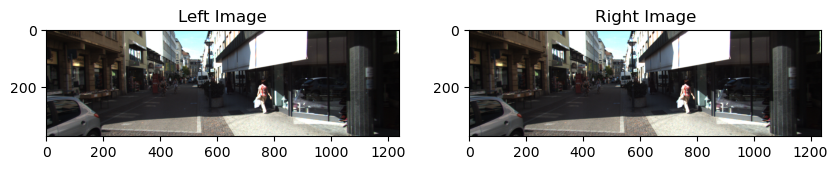

In [3]:
# Folder Names
train_folder = 'data/train'
validate_folder = 'data/validate'
sanity_folder = 'data/sanity'

# Showing a left and right image pair
left_img_path = 'data/train/left/0000000000.png'
left_img_path = 'data/train/right/0000000000.png'

# Load images
left_img = plt.imread(left_img_path)
right_img = plt.imread(left_img_path)

# Create a figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display left and right images side by side
axs[0].imshow(left_img)
axs[0].set_title('Left Image')

axs[1].imshow(right_img)
axs[1].set_title('Right Image')

plt.show()

## Transformations
We will apply various transforms to our input images in order to increase the diversity of the data, and allow for a more robust model.

- Resize to 187 x 619 for image consistency
- Randomly flip
- Random brightness 
- Random hue 
- Random contrast
- Random saturation

In [4]:
# Could work on just 1 image (left) or both (left and right)
class JointToTensor(object):
    def __call__(self, target):
        if isinstance(target, list) or isinstance(target, tuple):
            return tF.to_tensor(target[0]), tF.to_tensor(target[1])
        return tF.to_tensor(target)

# Randomly horizontally flip the images
class JointRandomFlip(object):
    def __call__(self, target):
        if random.random() > 0.5: # 50% chance of flipping
            if isinstance(target, list) or isinstance(target, tuple):
                return tF.hflip(target[0]), tF.hflip(target[1])
            return tF.hflip(target)
        return target

# Could work on just 1 image (left) or both (left and right)
# Resize image to make learning easier/more consistent inputs
class JointResize(object):
    def __init__(self, size=(256, 512)):
        self.resize = transforms.Resize(size)
        
    def __call__(self, target):
        if isinstance(target, list) or isinstance(target, tuple):
            return self.resize(target[0]), self.resize(target[1])
        return self.resize(target)

# Adjust brightness randomly
class JointRandomBrightness(object):
    def __init__(self, brightness_factor_range=(0.7, 1.3)):
        self.brightness_factor_range = brightness_factor_range

    def __call__(self, target):
        brightness_factor = random.uniform(*self.brightness_factor_range)
        if isinstance(target, list) or isinstance(target, tuple):
            return (tF.adjust_brightness(target[0], brightness_factor),
                    tF.adjust_brightness(target[1], brightness_factor))
        else:
            return target
            
# Adjust hue randomly
class JointRandomHue(object):
    def __init__(self, hue_factor_range=(-0.1, 0.1)):
        self.hue_factor_range = hue_factor_range

    def __call__(self, target):
        hue_factor = random.uniform(*self.hue_factor_range)
        if isinstance(target, list) or isinstance(target, tuple):
            return (tF.adjust_hue(target[0], hue_factor),
                    tF.adjust_hue(target[1], hue_factor))
        else:
            return target

# Adjust contrast randomly
class JointRandomContrast(object):
    def __init__(self, contrast_factor_range=(0.7, 1.3)):
        self.contrast_factor_range = contrast_factor_range

    def __call__(self, target):
        contrast_factor = random.uniform(*self.contrast_factor_range)
        if img_right is not None:
            return (tF.adjust_contrast(target[0], contrast_factor),
                    tF.adjust_contrast(target[1], contrast_factor))
        else:
            return target

# Adjust saturation randomly
class JointRandomSaturation(object):
    def __init__(self, saturation_factor_range=(0.7, 1.3)):
        self.saturation_factor_range = saturation_factor_range

    def __call__(self, target):
        saturation_factor = random.uniform(*self.saturation_factor_range)
        if img_right is not None:
            return (tF.adjust_saturation(target[0], saturation_factor),
                    tF.adjust_saturation(target[1], saturation_factor))
        else:
            return target


## Data Loading

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset

# Get images
class KITTIDataset(Dataset):
    def __init__(self, root, mode, transform=None):
        self.transform = transform
        
        left_dir = os.path.join(root, mode, 'left')
        self.left_images = sorted([os.path.join(left_dir, img) 
                for img in os.listdir(left_dir) if img.endswith('.png')])
        
        right_dir = os.path.join(root, mode, 'right')
        self.right_images = sorted([os.path.join(right_dir, img) 
                for img in os.listdir(right_dir) if img.endswith('.png')])

        assert len(self.right_images) == len(self.left_images)
        
    def __len__(self):
        return len(self.left_images)

    def __getitem__(self, imgNum):
        left_image = Image.open(self.left_images[imgNum])
        right_image = Image.open(self.right_images[imgNum])
            
        if self.transform:
            return self.transform((left_image, right_image))
        return left_image, right_image

In [6]:
# Composing transforms for our datasets
training_transform = transforms.Compose([ 
    JointToTensor(), 
    JointResize(),
    JointRandomBrightness(), 
    JointRandomContrast(), 
    JointRandomHue(), 
    JointRandomSaturation(), 
    JointRandomFlip(), 
])
validation_transform = transforms.Compose([ JointToTensor(), JointResize()
])
sanity_transform = transforms.Compose([ JointToTensor(), JointResize()
])

#### Creating the datasets:

In [7]:
train_dataset = KITTIDataset('data', 'train', transform=training_transform)
print("The length of the training set is: ", len(train_dataset))

The length of the training set is:  1059


In [8]:
validate_dataset = KITTIDataset('data', 'validate', transform=validation_transform)
print("The length of the validation set is: ", len(validate_dataset))

The length of the validation set is:  106


In [9]:
sanity_dataset = KITTIDataset('data', 'sanity', transform=sanity_transform)
print("The length of the sanity set is: ", len(sanity_dataset))

The length of the sanity set is:  1


#### Creating loaders for the datasets:

In [37]:
# Increase TRAIN_BATCH_SIZE if you are using GPU to speed up training. 
# When batch size changes, the learning rate may also need to be adjusted. 
# Note that batch size maybe limited by your GPU memory, so adjust if you get 
# "run out of GPU memory" error.
TRAIN_BATCH_SIZE = 1

VAL_BATCH_SIZE = 1
# If you are NOT using Windows, set NUM_WORKERS to anything you want, e.g. NUM_WORKERS = 4,
# but Windows has issues with multi-process dataloaders, so NUM_WORKERS must be 0 for Windows.
NUM_WORKERS = 0

sanity_loader = DataLoader(sanity_dataset, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(validate_dataset, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

# Model
The depth estimation neural network that the Godard et al paper recommends is as follows:

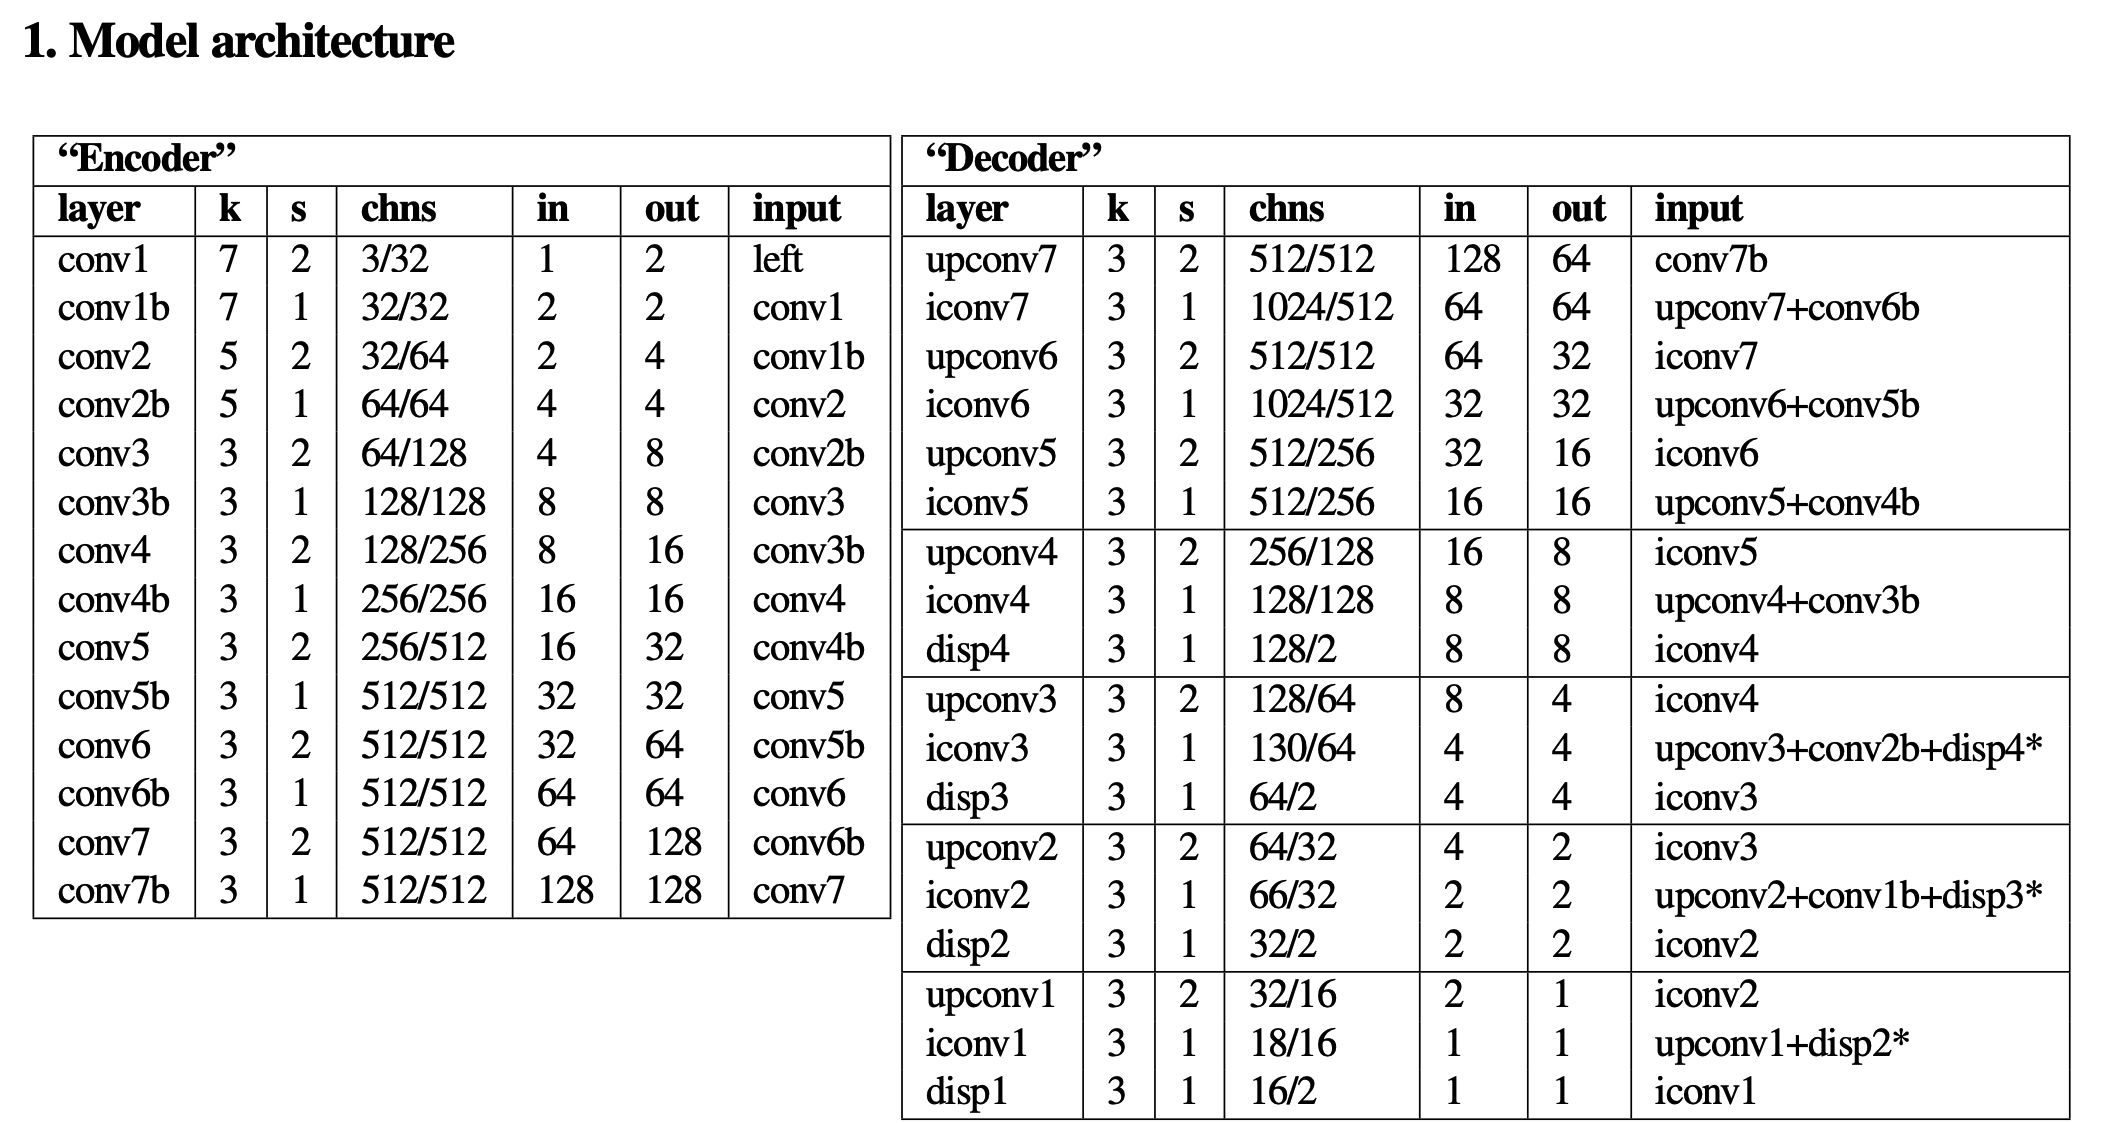

The encoder consists of several convolutional kernals (cnv1 to cnv7b). We will use Resnet-18.

The decoder uses skip-connections from the encoder’s activation blocks, enabling it to resolve higher resolution details. The decoder also outputs disparity predictions at four different scales (disp4 to disp1), which double in resolution at each level.  

The network predicts two disparity maps at each output scale: left-to-right and right-to-left.

## Helper methods for the decoder:

In [11]:
class iconv(nn.Module):
    def __init__(self, in_layers, out_layers, kernel_size, stride):
        super(iconv, self).__init__()
        padding = int(np.floor((kernel_size-1)/2))
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_layers, out_layers, kernel_size, stride, padding),
            nn.BatchNorm2d(out_layers),
            nn.ELU(inplace=True),
        )

    def forward(self, x):
        return self.layers(x)

class upconv(nn.Module):
    def __init__(self, in_layers, out_layers, kernel_size, scale):
        super(upconv, self).__init__()
        self.scale = scale
        self.layers = iconv(in_layers, out_layers, kernel_size, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale, mode='bilinear', 
                          align_corners=True)
        return self.layers(x)

class disp(nn.Module):
    def __init__(self, num_in_layers):
        super(disp, self).__init__()
        self.conv = nn.Conv2d(num_in_layers, 2, kernel_size=3, stride=1, padding=1)
        self.normalize = nn.BatchNorm2d(2)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = self.normalize(x)
        return 0.3 * self.sigmoid(x)

## Implementing the Network (Encoder and Decoder Layers)

In [12]:
import torchvision.models as models

class MyNet(nn.Module):
    def __init__(self, criterion=None):
        super(MyNet, self).__init__()

        # Encoding layers
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.criterion = criterion # Loss function

        ds5 = nn.Sequential(
                    nn.Conv2d(512, 512, kernel_size=(1, 1), stride=(2, 2), bias=False),
                    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, 
                                   track_running_stats=True),
        )
        # Additional layers for the encoder to follow paper
        self.layer5 = models.resnet.BasicBlock(512, 512, stride=(2, 2), downsample=ds5)
        self.layer6 = models.resnet.BasicBlock(512, 512)

        # Decoding layers
        self.upconv7 = upconv(512, 512, 3, 2)
        self.iconv7 = iconv(512 + 512, 512, 3, 1)
    
        self.upconv6 = upconv(512, 512, 3, 2)
        self.iconv6 = iconv(256 + 512, 512, 3, 1)

        self.upconv5 = upconv(512, 256, 3, 2)
        self.iconv5 = iconv(128 + 256, 256, 3, 1)

        self.upconv4 = upconv(256, 128, 3, 2)
        self.iconv4 = iconv(64 + 128, 128, 3, 1)
        self.disp4_layer = disp(128)

        self.upconv3 = upconv(128, 64, 3, 1)
        self.iconv3 = iconv(64 + 64 + 2, 64, 3, 1)
        self.disp3_layer = disp(64)

        self.upconv2 = upconv(64, 32, 3, 2)
        self.iconv2 = iconv(64 + 32 + 2, 32, 3, 1)
        self.disp2_layer = disp(32)

        self.upconv1 = upconv(32, 16, 3, 2)
        self.iconv1 = iconv(16 + 2, 16, 3, 1)
        self.disp1_layer = disp(16)

    
    def forward(self, left, right=None):
        
        # Encoder
        skip1 = self.resnet18.conv1(left) 
        s1 = self.resnet18.bn1(skip1)
        s1 = self.resnet18.relu(s1)
        skip2 = self.resnet18.maxpool(s1)
        skip3 = self.resnet18.layer1(skip2)
        skip4 = self.resnet18.layer2(skip3)
        skip5 = self.resnet18.layer3(skip4)
        skip6 = self.resnet18.layer4(skip5)
        skip7 = self.layer5(skip6) 
        x = self.layer6(skip7)

        # Decoder       
        upconv7 = self.upconv7(x)
        iconv7 = self.iconv7(torch.cat((upconv7, skip6), 1))
        
        upconv6 = self.upconv6(iconv7)
        iconv6 = self.iconv6(torch.cat((upconv6, skip5), 1))

        upconv5 = self.upconv5(iconv6)
        iconv5 = self.iconv5(torch.cat((upconv5, skip4), 1))

        upconv4 = self.upconv4(iconv5)
        iconv4 = self.iconv4(torch.cat((upconv4, skip3), 1))
        disp4 = self.disp4_layer(iconv4)
        udisp4 = nn.functional.interpolate(disp4, scale_factor=1, mode='bilinear', 
                                           align_corners=True)
        disp4 = nn.functional.interpolate(disp4, scale_factor=0.5, mode='bilinear', 
                                          align_corners=True)

        upconv3 = self.upconv3(iconv4)
        iconv3 = self.iconv3(torch.cat((upconv3, skip2, udisp4), 1))
        disp3 = self.disp3_layer(iconv3)
        udisp3 = nn.functional.interpolate(disp3, scale_factor=2, mode='bilinear', 
                                           align_corners=True)

        upconv2 = self.upconv2(iconv3)
        iconv2 = self.iconv2(torch.cat((upconv2, skip1, udisp3), 1))
        disp2 = self.disp2_layer(iconv2)
        udisp2 = nn.functional.interpolate(disp2, scale_factor=2, mode='bilinear', 
                                           align_corners=True)

        upconv1 = self.upconv1(iconv2)
        iconv1 = self.iconv1(torch.cat((upconv1, udisp2), 1))
        disp1 = self.disp1_layer(iconv1)

        if self.training:
            # Return the loss if in training mode
            return self.criterion([disp1, disp2, disp3, disp4], [left, right])              
        else:
            # Return the actual prediction otherwise
            return disp1



## Testing Untrained Network on a Sample

We will plot the original left and right image, and then their disparity maps that the untrained neural network gives us.

In [13]:
def display_disparity(net, dataset, i, disp_show=True):
    net.eval()
    sample = dataset[i]
    dmap = net.forward(sample[0][None].to(device)).to('cpu').detach()

    dmapL = dmap[:,0,:,:].unsqueeze(1)
    dmapR = dmap[:,1,:,:].unsqueeze(1)

    if disp_show:
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(2,2,1)
        plt.title('Left Image')
        ax.imshow(sample[0].permute(1, 2, 0))
        ax = fig.add_subplot(2,2,2)
        plt.title('Right Image')
        ax.imshow(sample[1].permute(1, 2, 0))
        ax = fig.add_subplot(2,2,3)
        plt.title('Left Dmap')
        ax.imshow(dmapL[0][0])
        ax = fig.add_subplot(2,2,4)
        plt.title('Right Dmap')
        ax.imshow(dmapR[0][0])

    return dmap

/Users/nimunbajwa/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


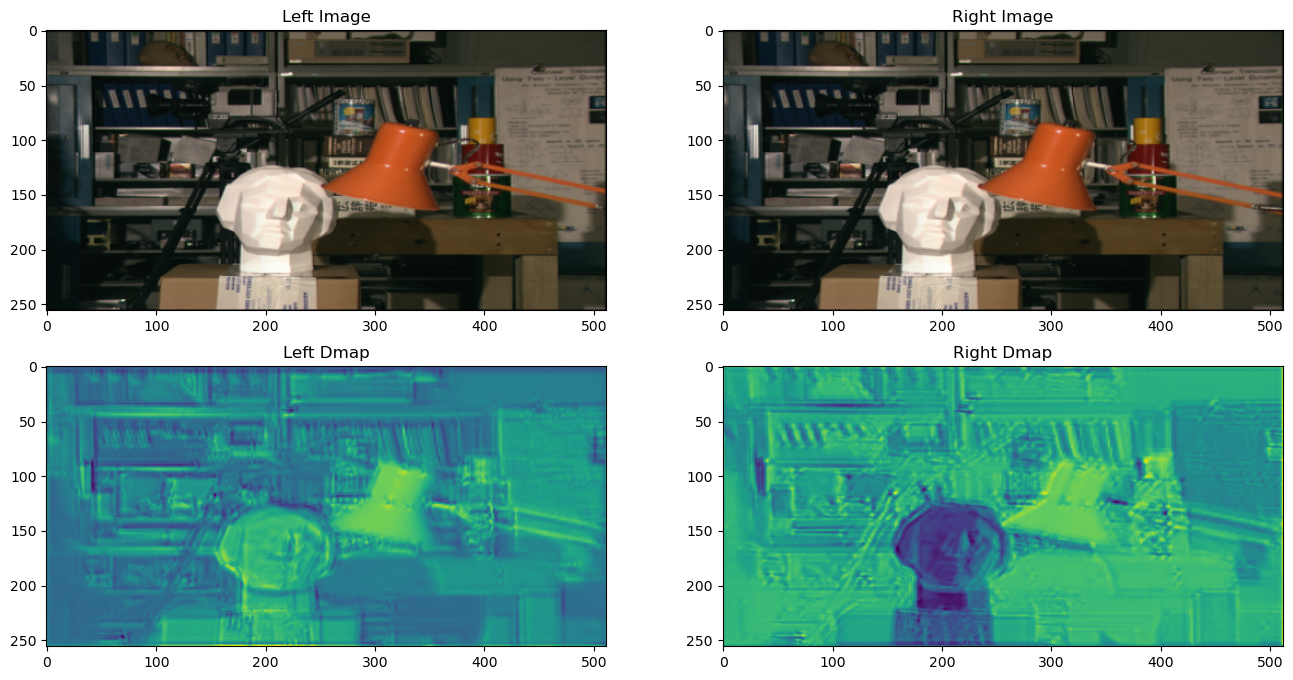

In [14]:
# Test the untrained network on some sample images
untrained_net = MyNet().eval().to(device)
dmap = display_disparity(untrained_net, sanity_dataset, 0)

It looks like we're getting our disparity maps from the untrained neural network. Let's define our loss function now.

# Loss

The loss function that is proposed by the paper consists of 3 components:
- Appearance Matching Loss $C_{ap}$: How similar is the reconstructed image to the original image. This loss uses the L1 norm and Structural Similarity Index measure (SSIM) for the comparison. 
$$C_{ap} = \frac{1}{N} \sum_{ij} \alpha \frac{1-SSIM(I_{ij}\tilde{I_{ij}})}{2} + (1-\alpha) \|I_{ij}- \tilde{I_{ij}} \|$$

- Disparity Smoothness Loss $C_{ds}$: Encouraging smoothness in disparities. This loss uses an L1 penalty on the disparity gradients.
$$C_{ds} = \frac{1}{N} \sum_{ij} |\partial_x d_{ij}|e^{-\| \partial_x I_{ij}\|} + |\partial_y d_{ij}|e^{-\| \partial_y I_{ij}\|}$$

- Left-Right Disparity Consistency Loss $C_{lr}$: Encouraging consistency between left and right image disparities. This loss uses an L1 left-right disparity consistency penalty.  
$$C_{lr} = \frac{1}{N} \sum_{ij} |d^l_{ij}-d^r_{ij+d^l_{ij}}|$$

These losses are defined for left and right images.

The total monocular depth loss is:

$$C_s = \alpha_{ap}(C^l_ap+C^r_ap) + \alpha_{ds}(C^l_ds+C^r_ds) + \alpha_{lr}(C^l_lr+C^r_lr)$$

Where Here, $\alpha_{ap} = 1, \alpha_{ds} = \frac{1}{r}, \alpha_{lr} = 1$ are the weights assigned to each type of loss. 


### Image Generation
One major concept in this paper is how the right image is recreated using the left image and the left-right disparity map. We will be implementing the method that does this below:

In [15]:
def generate_image(img_L, LtoRdmap):
    """
    args:
        img_L: tensor of size [batch_size, channels, height, width]
        LtoRdmap: tensor of size [batch_size, channels, height, width]

        Return:
            (tensor): generated img_R using img_L and disparity map
    """
    
    batch_size, channels, height, width = img_L.shape
    LtoRdmap = LtoRdmap[:, 0, :, :].to(device)
    
    # Normalize pixel positions to [0, 1]
    a = torch.linspace(0, 1, height)
    b = torch.linspace(0, 1, width)
    meshy, meshx = torch.meshgrid(a, b)
    meshx = meshx.repeat(batch_size, 1, 1).to(device)
    meshy = meshy.repeat(batch_size, 1, 1).to(device)
    
    flowfield = torch.stack((meshx + LtoRdmap, meshy), dim=3).type_as(img_L)
    return F.grid_sample(img_L, 2 * flowfield - 1, mode='bilinear', padding_mode='zeros')

## Appearance Matching Loss

How similar is the reconstructed image to the original image.
$$C_{ap} = \frac{1}{N} \sum_{ij} \alpha \frac{1-SSIM(I_{ij}\tilde{I_{ij}})}{2} + (1-\alpha) \|I_{ij}- \tilde{I_{ij}} \|$$

In [16]:
class appearanceMatchingLoss(nn.modules.Module):
    """
        Compares the reconstructed image with the original image
        Args:
            dmap: disparity map
            img: input image (reconstructed)
            alpha: float from 0-1 (used in SSIM)
        Return:
            (float): appearance matching loss
        """
    def __init__(self, alpha = 0.85):
        super(appearanceMatchingLoss, self).__init__()
        self.alpha = alpha

    # SSIM implementation from 
        # https://github.com/mrharicot/monodepth/blob/master/monodepth_model.py#L91
    def SSIM(self, x, y):
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        mu_x = nn.AvgPool2d(3, 1)(x)
        mu_y = nn.AvgPool2d(3, 1)(y)
        mu_x_mu_y = mu_x * mu_y
        mu_x_sq = mu_x.pow(2)
        mu_y_sq = mu_y.pow(2)

        sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
        sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
        sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

        SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
        SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
        SSIM = SSIM_n / SSIM_d

        return torch.clamp((1 - SSIM) / 2, 0, 1)
        
    def forward(self, x, y):
        ssim = self.SSIM(x, y)
        ssim_loss = self.alpha * torch.mean(ssim)
        mae = (1 - self.alpha) * torch.mean(torch.abs(x - y))
        return ssim_loss + mae

## Disparity Smoothness Loss

Encouraging smoothness in disparities.
$$C_{ds} = \frac{1}{N} \sum_{ij} |\partial_x d_{ij}|e^{-\| \partial_x I_{ij}\|} + |\partial_y d_{ij}|e^{-\| \partial_y I_{ij}\|}$$

In [17]:
class disparitySmoothnessLoss(nn.modules.Module):
    """
        Encourages smoothness, penalizes discontinuities
        in disparities
        Args:
            dmap: disparity map
            img: input image
        Return:
            (float): disparity smoothness loss
        """
    def __init__(self):
        super(disparitySmoothnessLoss, self).__init__()
    
    # Calculating gradients
    def gradientX(self, img):
        img = F.pad(img, (0, 1, 0, 0), mode="replicate")
        return img[:, :, :, :-1] - img[:, :, :, 1:]
    def gradientY(self, img):
        img = F.pad(img, (0, 0, 0, 1), mode="replicate")
        return img[:, :, :-1, :] - img[:, :, 1:, :]  
    
    def forward(self, dmap, img):
        dmapDX = torch.abs(self.gradientX(dmap))
        dmapDY = torch.abs(self.gradientY(dmap))
        imgDX = torch.abs(self.gradientX(img))
        imgDY = torch.abs(self.gradientY(img))
        
        dslDX = dmapDX * torch.exp(-torch.mean(imgDX, 1, keepdim=True))
        dslDY = dmapDY * torch.exp(-torch.mean(imgDY, 1, keepdim=True))
        return torch.mean(dslDX + dslDY)

## Left-Right Disparity Consistency Loss

Encouraging consistency between left and right image disparities.
$$C_{lr} = \frac{1}{N} \sum_{ij} |d^l_{ij}-d^r_{ij+d^l_{ij}}|$$

In [18]:
class leftRightConsistencyLoss(nn.modules.Module):
    """
        Args:
            dmapL: left disparity map
            dmapR: right disparity map
        Return:
            (float): left-right consistency loss
    """
    def __init__(self):
        super(leftRightConsistencyLoss, self).__init__()
    
    def forward(self, dmapL, dmapR):
        dmapProjR = generate_image(dmapR, -dmapL)
        dmapProjL = generate_image(dmapL, dmapR)
        mProjR = torch.mean(torch.abs(dmapProjR  - dmapL))
        mProjL = torch.mean(torch.abs(dmapProjL  - dmapR))
        return mProjL + mProjR

## Overall Monocular Depth Loss
The total monocular depth loss is:

$$C_s = \alpha_{ap}(C^l_ap+C^r_ap) + \alpha_{ds}(C^l_ds+C^r_ds) + \alpha_{lr}(C^l_lr+C^r_lr)$$

Where Here, $\alpha_{ap} = 1, \alpha_{ds} = \frac{1}{r}, \alpha_{lr} = 1$ are the weights assigned to each type of loss. 

In [19]:
def scale(img):
    """
        Scales the images by a factor of 1, 0.5, 0.25, and 0.125.
        Args:
            img: input image
        Return:
            (list): list of images that are scaled
    """
    images = []
    _, _, h, w = img.size()

    for scale in [1, 0.5, 0.25, 0.125]:
        newSize = (int(h * s), int(w * s))
        scaledImg = F.interpolate(img, size=newSize, mode='bilinear', 
                                  align_corners=True)
        images.append(scaledImg)
    return images

In [20]:
class monocularDepthLoss(nn.modules.Module):
    def __init__(self, device='cpu', alpha_ap = 1, alpha_ds = 1, alpha_lr = 1):
        super(monocularDepthLoss, self).__init__()
        self.alpha_ap = alpha_ap
        self.alpha_ds = alpha_ds
        self.alpha_lr = alpha_lr
        self.C_ap = appearanceMatchingLoss().to(device)
        self.C_ds = disparitySmoothnessLoss().to(device)
        self.C_lr = leftRightConsistencyLoss().to(device)
    
    def scale(self, img):
        """
            Scales the images by a factor of 1, 0.5, 0.25, and 0.125.
            Args:
                img: input image
            Return:
                (list): list of images that are scaled
        """
        images = []
        _, _, h, w = img.size()
    
        for scale in [1, 0.5, 0.25, 0.125]:
            newSize = (int(h * scale), int(w * scale))
            scaledImg = F.interpolate(img, size=newSize, mode='bilinear', 
                                      align_corners=True)
            images.append(scaledImg)
        return images
    
    def __call__(self, input, target):
        """
        Args:
            input [disp1, disp2, disp3, disp4]
            target [left, right]
        Return:
            (float): monocular depth loss
        """
        imgL, imgR = target
        imgL_scaled = self.scale(imgL)
        imgR_scaled = self.scale(imgR)

        dmapL = [dmap[:, 0, :, :].unsqueeze(1) for dmap in input]
        dmapR = [dmap[:, 1, :, :].unsqueeze(1) for dmap in input]
        
        # Shift left when using the left dmap
        imgL_reconstructed = [generate_image(im, -dmap) 
                              for im, dmap in zip(imgR_scaled, dmapL)]
        imgR_reconstructed = [generate_image(im, dmap) 
                              for im, dmap in zip(imgL_scaled, dmapR)]
        
        # Appearance matching loss
        apLoss_L = [self.C_ap(input, target) 
                    for input, target in zip(imgL_reconstructed, imgL_scaled)]
        apLoss_R = [self.C_ap(input, target) 
                    for input, target in zip(imgR_reconstructed, imgR_scaled)]
        
        self.lossAP = self.alpha_ap * sum(apLoss_L + apLoss_R)
        
        # Disparity Smoothness loss
        dsLoss_L = [self.C_ds(dmapL[i], dmapR[i]) / 2 ** i for i in range(4)]
        dsLoss_R = [self.C_ds(dmapR[i], dmapL[i]) / 2 ** i for i in range(4)]
        
        self.lossDS = self.alpha_ds * sum(dsLoss_L + dsLoss_R)
        
        # Left Right Consistency Loss
        self.lossLR = self.alpha_lr * sum([self.C_lr(L, R) for L, R in zip(dmapL, dmapR)])
        
        return self.lossAP + self.lossDS + self.lossLR

## Disparity Sample

We will use the sample displarity maps and images below to test our loss functions.

/Users/nimunbajwa/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/Users/nimunbajwa/anaconda3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/nimunb

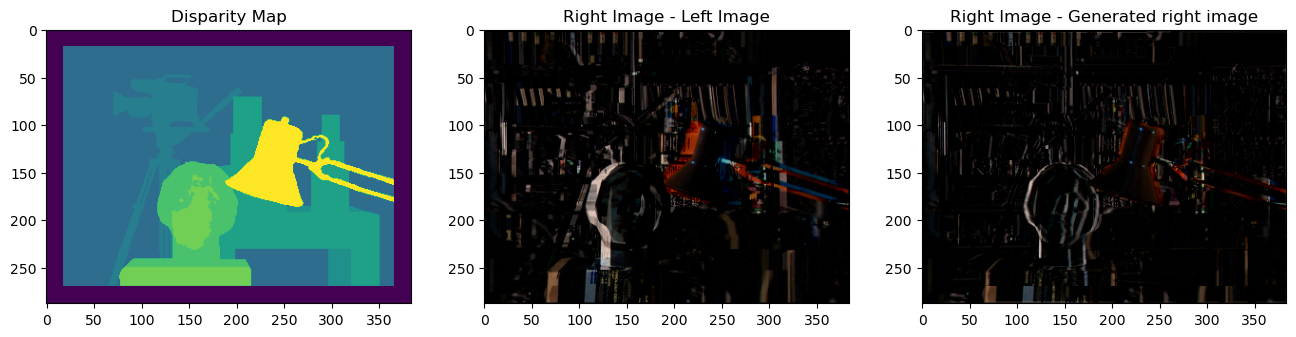

In [21]:
import matplotlib.image as image

# Retrieving Images
img_left = tF.to_tensor(image.imread("images/scene1.row3.col3.ppm"))
img_right = tF.to_tensor(image.imread("images/scene1.row3.col4.ppm"))
img_gt = torch.from_numpy(image.imread("images/truedisp.row3.col3.pgm") / 16)
img_gt = img_gt / img_gt.shape[0]

generatedImgR = generate_image(img_left[None], img_gt[None, None])

# Displaying images
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,3,1)
plt.title('Disparity Map')
ax.imshow(img_gt)

ax = fig.add_subplot(1,3,2)
plt.title('Right Image - Left Image')
ax.imshow((img_right - img_left).permute(1, 2, 0))

ax = fig.add_subplot(1,3,3)
plt.title('Right Image - Generated right image')
ax.imshow(img_right.permute(1, 2, 0) - generatedImgR[0].permute(1, 2, 0))

### Testing Appearance Matching Loss Calculation

In [22]:
print(appearanceMatchingLoss()(img_right[None], generatedImgR))

tensor(0.1623)


### Testing Disparity Smoothness Loss Calculation

In [23]:
print(disparitySmoothnessLoss()(img_gt[None, None], img_left[None]))
print(disparitySmoothnessLoss()(img_left[None], img_gt[None, None]))

tensor(0.0006, dtype=torch.float64)
tensor(0.0545, dtype=torch.float64)


### Testing Left-Right Disparity Consistency Loss Calculation

In [27]:
print(leftRightConsistencyLoss()(img_gt[None, None], img_gt[None, None]))

tensor(0.0042, dtype=torch.float64)


### Testing Overall Monocular Depth Loss Calculation

In [28]:
test = [torch.stack((dmap[:,0], dmap[:,0]), dim=1) 
        for dmap in monocularDepthLoss().scale(img_gt[None, None])]
print("Test Image Shape: ", test[0].shape)
print("Test Prediction: ", monocularDepthLoss()(test, [img_left[None], img_right[None]]))

Test Image Shape:  torch.Size([1, 2, 288, 384])
Test Prediction:  tensor(1.3256, dtype=torch.float64)


# Training

### Training Loop
Here we will define the training loop for the ML model.

In [38]:
def train(train_loader, net, optimizer, loss_graph):
    net.train()
    for i, data in enumerate(train_loader):
        left = data[0].to(device)
        right = data[1].to(device)
        
        optimizer.zero_grad()
        main_loss = net(left=left, right=right)
        loss_graph.append(main_loss.item()) # Populate this list to graph the loss
        main_loss.backward()
        optimizer.step()
        
    return main_loss

## Overfitting the network: Training on a single image pair

From A5: Single image training is helpful for debugging and hyper-parameter tuning (e.g. learning rate, etc.) as it is fast even on a single CPU. In particular, you can work with a single image until your loss function is consistently decreasing during training loop and the network starts producing a reasonable output for this training image. Training on a single image also teaches about overfitting, particualrly when comparing it with more thorough forms of network training.

We will operate on our sanity dataset.

Starting Training...
Epoch: 0 Loss: 3.6375668048858643
Epoch: 1 Loss: 3.418206214904785
Epoch: 2 Loss: 3.2668352127075195
Epoch: 3 Loss: 3.185068130493164
Epoch: 4 Loss: 3.158088207244873
Epoch: 5 Loss: 3.0712218284606934
Epoch: 6 Loss: 3.043506622314453
Epoch: 7 Loss: 2.9944636821746826
Epoch: 8 Loss: 2.96956729888916
Epoch: 9 Loss: 2.9461679458618164
Epoch: 10 Loss: 2.9035425186157227
Epoch: 11 Loss: 2.8825979232788086
Epoch: 12 Loss: 2.8767805099487305
Epoch: 13 Loss: 2.8470005989074707
Epoch: 14 Loss: 2.8290233612060547
Epoch: 15 Loss: 2.806981325149536
Epoch: 16 Loss: 2.7829670906066895
Epoch: 17 Loss: 2.7670891284942627
Epoch: 18 Loss: 2.7474145889282227
Epoch: 19 Loss: 2.7258591651916504
Epoch: 20 Loss: 2.7132880687713623
Epoch: 21 Loss: 2.7008438110351562
Epoch: 22 Loss: 2.687986373901367
Epoch: 23 Loss: 2.6738545894622803
Epoch: 24 Loss: 2.6552116870880127
Epoch: 25 Loss: 2.6439342498779297
Epoch: 26 Loss: 2.6408944129943848
Epoch: 27 Loss: 2.63472843170166
Epoch: 28 Loss: 2.6

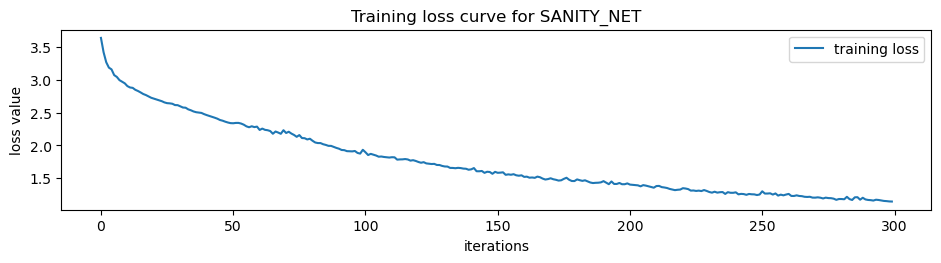

In [42]:
%%time
%matplotlib notebook
%matplotlib inline

sanity_net = MyNet().to(device)

# set loss function for the net
sanity_net.criterion = monocularDepthLoss(device).to(device)

loader = sanity_loader
optimizer = torch.optim.Adam(sanity_net.parameters(), lr=0.01)

EPOCH = 300

# switch to train mode
sanity_net.train()

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.5)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(loader, sanity_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for SANITY_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

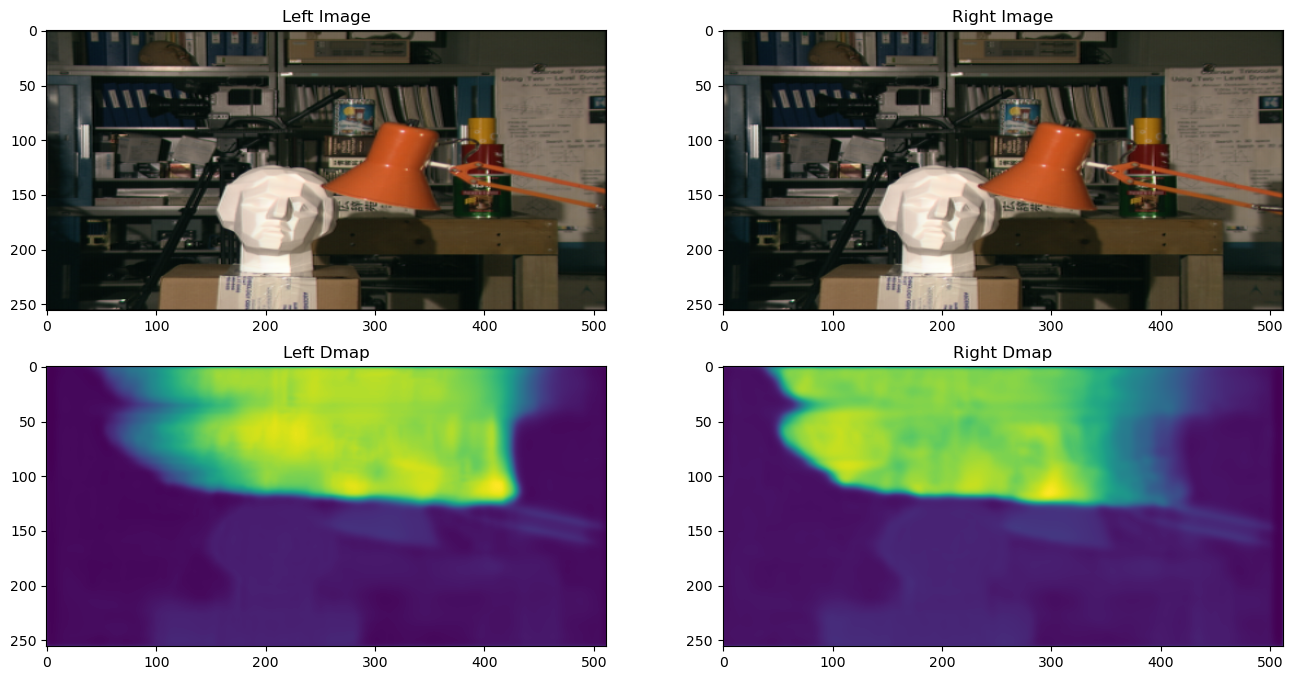

In [44]:
# Test the untrained network on some sample images
dmap = display_disparity(sanity_net, sanity_dataset, 0)

We can see that apart from the big green blob, the rest of the disparity map is looking as expected. 
To be specific, we can make out the shape of the lamp and the figure head, which is really great! If you look closer, we can see outlines of the table as well.

So overall, we can see four different disparity levels (in order of depth): lamp, figure head, table, background, which I am happy about.

Now, let's discuss the big green blob. I'm not entirely sure why it's there. I would re-run if I had more time, but unfortunately I don't. If I had to speculate about why it's there, it might have something to do with our learning model getting stuck in an unseen minima, which it can't get out of. 

I also would like to comment on the training loss curve, which is decreasing with more epochs, as expected. 

If I had more time, I would definitely use the multi-threading capabilities of the NVIDIA GPU. I unfortunately have an older machine, and Google Colab was taking a very long time to upload all my data onto. 

## Training on the entire training dataset (1059 images)

In [ ]:
%%time
%matplotlib notebook
%matplotlib inline

train_net = MyNet().to(device)

# set loss function for the net
train_net.criterion = monocularDepthLoss(device).to(device)

loader = train_loader
optimizer = torch.optim.Adam(train_net.parameters(), lr=0.01)

EPOCH = 3

# switch to train mode
train_net.train()

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.5)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(loader, train_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for TRAIN_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

Starting Training...
